In [1]:
%pip install lmfit
%pip install xlrd
%pip install pybroom
%pip install openpyxl

In [2]:
%pip install -q ipympl

In [3]:
import scipy
import matplotlib.pyplot as plt
import lmfit
import io
import numpy as np
import pandas as pd
import pybroom as pb

In [4]:
%matplotlib inline

# Read rheology data

In [5]:
Data_file=pd.ExcelFile('carbopol_0_25.xls')
Data_file.sheet_names

['Details', 'Flow sweep - 1', 'Amplitude sweep - 2']

In [17]:
data=Data_file.parse('Flow sweep - 1',skiprows=[0,2])
data_osc=Data_file.parse('Amplitude sweep - 2',skiprows=[0,2])
data.head()


,Stress,Shear rate,Viscosity,Step time,Temperature,Normal stress
0,132.6630,1000.000,0.132663,9.24419,20.00,535.123
1,118.9420,794.329,0.149739,18.52040,19.98,584.034
2,106.8730,630.958,0.169383,27.75740,19.98,612.867
3,96.2623,501.187,0.192069,37.02300,19.97,628.784
4,86.8722,398.107,0.218213,46.24510,19.96,636.450


# Microstructure information

https://sor.scitation.org/doi/pdf/10.1122/8.0000452

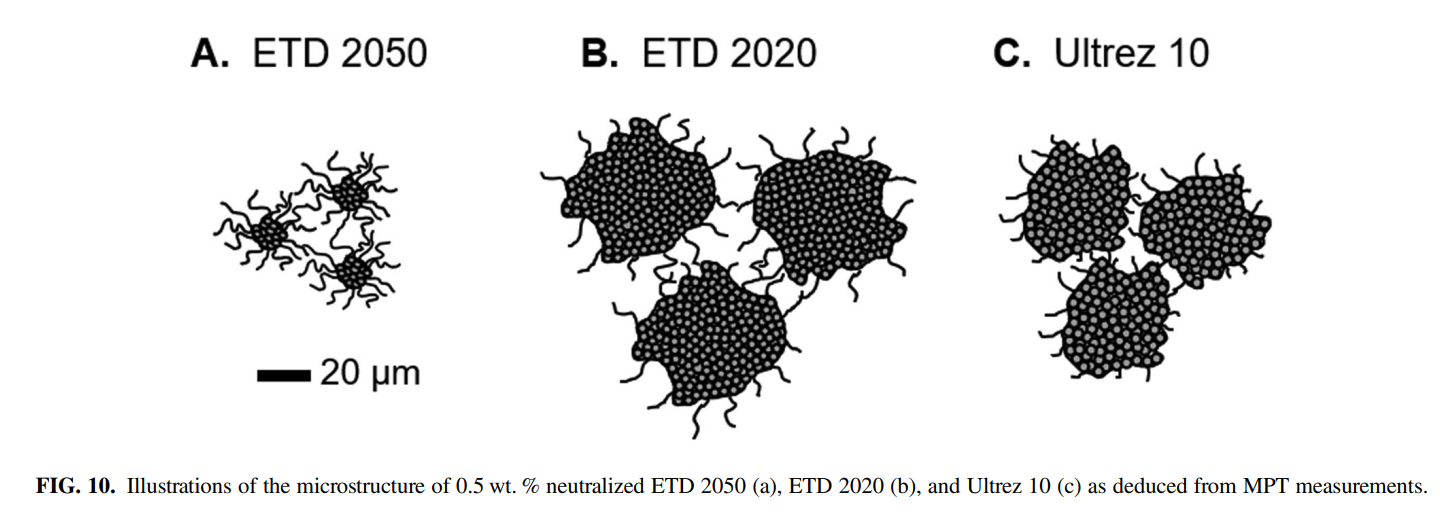

# define model : TCC
We define a TCC model as the combination of TC model describing the effect of crosslinked carbopol partilces and the Carreau model describing the non Newtonian properties of the continuos phase.

Recent characterization 
### Carreau Model

$$ \sigma=\dot\gamma \cdot \eta_0 \cdot (1+(\dot\gamma /\dot\gamma_{c})^2)^{(n-1)/2}$$

$$ \sigma_p=\eta_0 / \dot\gamma_{c} $$

### TC model

$$ \sigma = \sigma_y + \sigma_y (\dot\gamma / \dot\gamma_c)^{0.5} + \eta_{bg} \dot\gamma $$

### TCC model

$$ \sigma = \sigma_y + \sigma_y (\dot\gamma / \dot\gamma_c)^{0.5} + \dot\gamma \cdot \eta_0 \cdot (1+(\dot\gamma \eta_0 /\sigma_p)^2)^{(n-1)/2} $$

In [10]:
import lmfit

def carreau(x, eta_0=1.0, stress_plateau=100.0, n=0.5):
    
    return x * eta_0 * (1 + (x * eta_0 / stress_plateau) ** 2) ** ((n - 1) / 2)


carreau_model = lmfit.Model(carreau, prefix="carreau_")

carreau_model.set_param_hint("eta_0", min=0)
carreau_model.set_param_hint("n", min=0, max=1)
carreau_model.set_param_hint("stress_plateau", min=0, max=1000)



def TC(x, ystress=1.0, eta_bg=0.1, gammadot_crit=0.1):

    return ystress + ystress * (x / gammadot_crit) ** 0.5 + eta_bg * x


TC_model = lmfit.Model(TC, prefix="TC_")

TC_model.set_param_hint("ystress", min=0, vary=True)
TC_model.set_param_hint("eta_bg", min=0, vary=True)
TC_model.set_param_hint("gammadot_crit", min=0)


TC_model.set_param_hint("TC_eta_bg", value=0, vary=False)
TC_model.set_param_hint("TC_ystress", value=0.001, vary=True)
carreau_model.set_param_hint("carreau_n", value=0, vary=True)

TCC_model = TC_model + carreau_model

In [11]:
res_fit_TCC=TCC_model.fit(data['Stress'],x=data['Shear rate'], weights=1/data['Stress'])

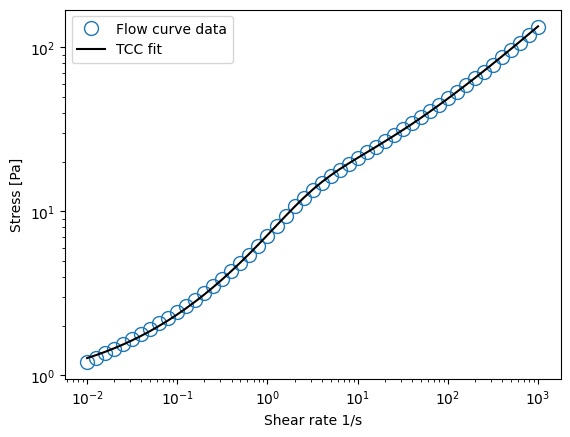

In [12]:
plt.plot(data['Shear rate'], data['Stress'], 'o', label='Flow curve data', mfc='none', markersize=10)
plt.plot(data['Shear rate'],res_fit_TCC.best_fit, label='TCC fit', color='black')

plt.xlabel('Shear rate 1/s')
plt.ylabel('Stress [Pa]')
plt.xscale('log')
plt.yscale('log')
plt.legend()

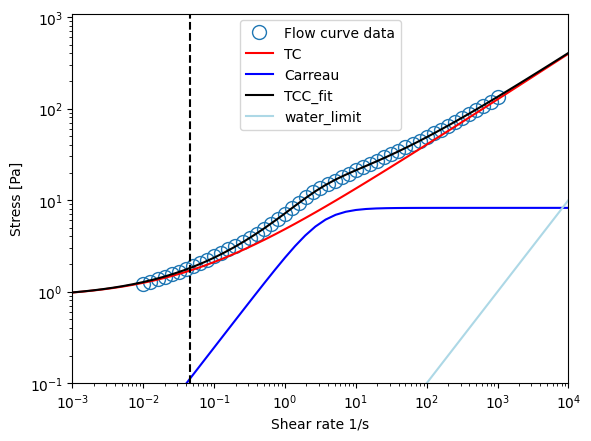

In [13]:
import numpy as np
x=np.logspace(-3,4)
plt.plot(data['Shear rate'], data['Stress'], 'o', label='Flow curve data', mfc='none', markersize=10)
plt.plot(x,res_fit_TCC.eval_components(x=x)['TC_'], label='TC', color='red')
plt.plot(x,res_fit_TCC.eval_components(x=x)['carreau_'], label='Carreau', color='blue')
plt.plot(x,res_fit_TCC.eval(x=x),label='TCC_fit', color='black')

plt.plot(x,0.001*x, label='water_limit', color='lightblue')


plt.axvline(res_fit_TCC.values['TC_gammadot_crit'], linestyle='--', color='black')


plt.xlabel('Shear rate 1/s')
plt.ylabel('Stress [Pa]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.1)
plt.xlim(0.001,10000)
plt.legend()

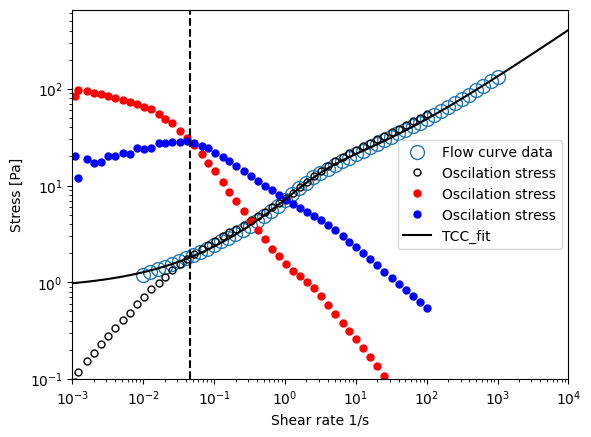

In [21]:
import numpy as np

x=np.logspace(-3,4)
plt.plot(data['Shear rate'], data['Stress'], 'o', label='Flow curve data', mfc='none', markersize=10)
plt.plot(data_osc['Oscillation strain rate'], data_osc['Oscillation stress'], '.', label='Oscilation stress', mfc='none',markersize=10, color='black')
plt.plot(data_osc['Oscillation strain rate'], data_osc['Storage modulus'], '.', label='Oscilation stress', markersize=10, color='red')
plt.plot(data_osc['Oscillation strain rate'], data_osc['Loss modulus'], '.', label='Oscilation stress', markersize=10, color='blue')


plt.plot(x,res_fit_TCC.eval(x=x),label='TCC_fit', color='black')

plt.axvline(res_fit_TCC.values['TC_gammadot_crit'], linestyle='--', color='black')


plt.xlabel('Shear rate 1/s')
plt.ylabel('Stress [Pa]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.1)
plt.xlim(0.001,10000)
plt.legend()

In [15]:
tidy_long=pb.tidy({'TCC':res_fit_TCC})
tidy_long

,name,value,min,max,vary,expr,stderr,init_value,key
0,TC_eta_bg,0.000000,0,inf,False,NaN,0.000000,0.000,TCC
1,TC_gammadot_crit,0.046175,0,inf,True,NaN,0.003604,0.100,TCC
2,TC_ystress,0.851664,0,inf,True,NaN,0.015422,0.001,TCC
3,carreau_eta_0,2.454550,0,inf,True,NaN,0.124400,1.000,TCC
4,carreau_n,0.000001,0,1.0,True,NaN,0.004921,0.000,TCC
5,carreau_stress_plateau,8.219956,0,1000.0,True,NaN,0.384675,100.000,TCC


In [16]:
tidy_wide=tidy_long.pivot(index='key',columns='name',values='value')
tidy_wide.reset_index()

name,key,TC_eta_bg,TC_gammadot_crit,TC_ystress,carreau_eta_0,carreau_n,carreau_stress_plateau
0,TCC,0.0,0.046175,0.851664,2.45455,0.000001,8.219956


In [ ]:
tidy_wide.reset_index().to_excel('results.xlsx')